# 데이터셋 준비

In [1]:
!pip install pydicom

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns
import torch.nn as nn

In [3]:
root = '/root'

## 데이터셋 관련 (공통)

In [4]:
import glob

L_list = glob.glob(f'{root}/mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

In [5]:
data_label = ['quarter_1mm', 'full_1mm']

In [6]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [7]:
def extract_patches(img, patch_size=55, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55, numpy

In [8]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []

    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [9]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches

In [10]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

## biomedclip (추가된 부분)

In [87]:
!pip install torch torchvision transformers open_clip_torch

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [88]:
import torch
from PIL import Image
from urllib.request import urlopen
from open_clip import create_model_from_pretrained, get_tokenizer

# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# 예제 이미지 및 텍스트
image_url = 'https://huggingface.co/microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224/resolve/main/example_data/biomed_image_classification_example_data/squamous_cell_carcinoma_histopathology.jpeg'
image = Image.open(urlopen(image_url))
texts = ['adenocarcinoma histopathology', 'squamous cell carcinoma histopathology']

# 이미지 및 텍스트 전처리
image_input = preprocess(image).unsqueeze(0).to(device)
text_input = tokenizer(texts).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = model(image_input, text_input)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(texts):
    print(f'{text}: {logits[0][i].item():.4f}')

adenocarcinoma histopathology: 0.0029
squamous cell carcinoma histopathology: 0.9971


In [13]:
text_descriptions = [
    # Head (두부)
    "brain",                # 뇌
    "skull",                # 두개골
    "cerebral hemispheres", # 대뇌 반구
    "ventricles",           # 뇌실
    "pituitary gland",      # 뇌하수체
    "sinuses",              # 부비동 (예: 상악동)

    # Chest (흉부)
    "lungs",                # 폐
    "heart",                # 심장
    "thoracic aorta",       # 흉부 대동맥
    "mediastinum",          # 종격동
    "bronchi",              # 기관지
    "ribs",                 # 갈비뼈

    # Abdomen (복부)
    "liver",                # 간
    "kidneys",              # 신장
    "pancreas",             # 췌장
    "spleen",               # 비장
    "abdominal aorta",      # 복부 대동맥
    "adrenal glands",       # 부신

    # 공통/기타
    "spine",                # 척추 (경추/흉추/요추 전체)
    "lymph nodes",          # 림프절
    "blood vessels"         # 혈관 (일반적 용어)
]

In [14]:
i,j = 0,0
L = L_list[i]
label = data_label[j]
dicom_files = glob.glob(f'{root}/mayo2016/{L}/{label}/*')
len(dicom_files)

560

In [89]:
import os
import pydicom
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# 이미지 불러오기
def load_dicom_image(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32)

    # 정규화 (0~1 사이로)
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)

    return Image.fromarray(img)

In [16]:
# 사용할 이미지
idx = 10
dicom_img = load_dicom_image(dicom_files[idx])
image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

text_tokens = tokenizer(text_descriptions).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = model(image_tensor, text_tokens)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(text_descriptions):
    print(f'{text}: {logits[0][i].item():.4f}')

brain: 0.0000
skull: 0.0000
cerebral hemispheres: 0.0000
ventricles: 0.0003
pituitary gland: 0.0000
sinuses: 0.0000
lungs: 0.9337
heart: 0.0000
thoracic aorta: 0.0002
mediastinum: 0.0534
bronchi: 0.0077
ribs: 0.0000
liver: 0.0001
kidneys: 0.0000
pancreas: 0.0000
spleen: 0.0030
abdominal aorta: 0.0000
adrenal glands: 0.0000
spine: 0.0015
lymph nodes: 0.0000
blood vessels: 0.0000


## (결과확인용) - 굳이 실행하지 않아도 됨

In [ ]:
# import torch
# import glob
# import numpy as np

# # 장기별 확률 저장용 딕셔너리
# organ_probs = {organ: [] for organ in text_descriptions}

# # 모든 데이터 순회
# for i, L in enumerate(L_list):
#     for j, label in enumerate(data_label):
#         dicom_files = glob.glob(f'{root}/mayo2016/{L}/{label}/*')

#         for dicom_file in dicom_files:
#             dicom_img = load_dicom_image(dicom_file)
#             image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

#             text_tokens = tokenizer(text_descriptions).to(device)

#             # 예측 수행
#             with torch.no_grad():
#                 image_features, text_features, logit_scale = model(image_tensor, text_tokens)
#                 logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

#             # 확률 저장
#             for idx, organ in enumerate(text_descriptions):
#                 organ_probs[organ].append(logits[0][idx].item())

In [ ]:
# # 장기별 확률 평균 계산
# organ_avg_probs = {organ: np.mean(probs) for organ, probs in organ_probs.items()}

# # 결과 출력
# for organ, avg_prob in organ_avg_probs.items():
#     print(f'{organ}: {avg_prob:.4f}')

brain: 0.0018
skull: 0.0383
cerebral hemispheres: 0.0218
ventricles: 0.1068
pituitary gland: 0.0012
sinuses: 0.0607
lungs: 0.1245
heart: 0.0000
thoracic aorta: 0.0065
mediastinum: 0.1065
bronchi: 0.0216
ribs: 0.0015
liver: 0.0147
kidneys: 0.0136
pancreas: 0.0333
spleen: 0.1516
abdominal aorta: 0.2299
adrenal glands: 0.0021
spine: 0.0509
lymph nodes: 0.0098
blood vessels: 0.0029


In [ ]:
# 아예 안나오는거 제거, 더 늘려보자.

In [ ]:
# text_descriptions = [
#     "skull",
#     "ventricles",
#     "lungs",
#     "mediastinum",
#     "liver",
#     "kidneys",
#     "pancreas",
#     "spleen",
#     "abdominal aorta",
#     "spine",
#     "lymph nodes"
# ]
# len(text_descriptions)

11

In [ ]:
# import torch
# import glob
# import numpy as np

# # 장기별 확률 저장용 딕셔너리
# organ_probs = {organ: [] for organ in text_descriptions}

# # 모든 데이터 순회
# for i, L in enumerate(L_list):
#     for j, label in enumerate(data_label):
#         dicom_files = glob.glob(f'{root}/mayo2016/{L}/{label}/*')

#         for dicom_file in dicom_files:
#             dicom_img = load_dicom_image(dicom_file)
#             image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

#             text_tokens = tokenizer(text_descriptions).to(device)

#             # 예측 수행
#             with torch.no_grad():
#                 image_features, text_features, logit_scale = model(image_tensor, text_tokens)
#                 logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

#             # 확률 저장
#             for idx, organ in enumerate(text_descriptions):
#                 organ_probs[organ].append(logits[0][idx].item())

In [ ]:
# # 장기별 확률 평균 계산
# organ_avg_probs = {organ: np.mean(probs) for organ, probs in organ_probs.items()}

# # 결과 출력
# for organ, avg_prob in organ_avg_probs.items():
#     print(f'{organ}: {avg_prob:.4f}')

skull: 0.0529
ventricles: 0.1261
lungs: 0.1362
mediastinum: 0.1226
liver: 0.0150
kidneys: 0.0154
pancreas: 0.0343
spleen: 0.1748
abdominal aorta: 0.2486
spine: 0.0596
lymph nodes: 0.0146


In [ ]:
# 경로별 사진에 대한 분류확률 저장하기

In [ ]:
# text_descriptions = [
#     "skull",
#     "ventricles",
#     "lungs",
#     "mediastinum",
#     "liver",
#     "kidneys",
#     "pancreas",
#     "spleen",
#     "abdominal aorta",
#     "spine",
#     "lymph nodes"
# ]
# len(text_descriptions)

11

In [ ]:
# import torch
# import glob
# import numpy as np
# import pandas as pd

# # 결과를 저장할 리스트
# data_list = []
# # organ_probs는 quater이미지, 즉 LDCT만 이용해서 사용
# label = data_label[0] # quarter_1mm

# # 모든 데이터 순회
# for i, L in enumerate(L_list[:]):
#     dicom_files = sorted(glob.glob(f'{root}/mayo2016/{L}/{label}/*'))

#     for dicom_file in dicom_files:
#         dicom_img = load_dicom_image(dicom_file)
#         image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

#         text_tokens = tokenizer(text_descriptions).to(device)

#         # 예측 수행
#         with torch.no_grad():
#             image_features, text_features, logit_scale = model(image_tensor, text_tokens)
#             logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

#         # (파일경로, [장기별 확률 리스트]) 저장
#         data_list.append((dicom_file, logits.squeeze(0).tolist()))

# # Pandas DataFrame 생성 및 저장
# df = pd.DataFrame([(path, *probs) for path, probs in data_list], columns=["File_Path"] + text_descriptions)
# df.to_csv(f"{root}/organ_probs.csv", index=False)

# print("저장 완료: organ_probs.csv")

저장 완료: organ_probs.csv


In [ ]:
# df

File_Path         skull  \
0     /content/drive/MyDrive/mayo2016/L067/quarter_1...  7.637076e-09   
1     /content/drive/MyDrive/mayo2016/L067/quarter_1...  1.852264e-07   
2     /content/drive/MyDrive/mayo2016/L067/quarter_1...  3.216340e-07   
3     /content/drive/MyDrive/mayo2016/L067/quarter_1...  1.126380e-07   
4     /content/drive/MyDrive/mayo2016/L067/quarter_1...  1.031356e-06   
...                                                 ...           ...   
1115  /content/drive/MyDrive/mayo2016/L067/full_1mm/...  8.373938e-03   
1116  /content/drive/MyDrive/mayo2016/L067/full_1mm/...  1.643301e-02   
1117  /content/drive/MyDrive/mayo2016/L067/full_1mm/...  6.806848e-03   
1118  /content/drive/MyDrive/mayo2016/L067/full_1mm/...  1.428727e-02   
1119  /content/drive/MyDrive/mayo2016/L067/full_1mm/...  1.182822e-02   

      ventricles     lungs  mediastinum     liver   kidneys      pancreas  \
0       0.000096  0.990584     0.008284  0.000027  0.000001  6.327128e-07   
1       0.001377  0.904238     0.091292  0.000044  0.000001  1.142121e-06   
2       0.002763  0.883216     0.108934  0.000095  0.000001  2.883918e-06   
3       0.000743  0.948592     0.043646  0.000091  0.000003  2.591629e-06   
4       0.002845  0.891784     0.092563  0.000092  0.000002  3.935392e-06   
...          ...       ...          ...       ...       ...           ...   
1115    0.862177  0.001520     0.015479  0.000070  0.000223  5.198091e-04   
1116    0.750394  0.003750     0.032290  0.000080  0.000220  1.583915e-03   
1117    0.914587  0.001670     0.010829  0.000057  0.000096  2.274695e-04   
1118    0.784546  0.003433     0.030958  0.000065  0.000233  1.944368e-03   
1119    0.848688  0.001948     0.020064  0.000050  0.000089  1.061776e-03   

        spleen  abdominal aorta     spine   lymph nodes  
0     0.000992     1.743743e-07  0.000016  3.297518e-07  
1     0.002676     1.090657e-06  0.000368  1.615580e-06  
2     0.004666     1.830558e-06  0.000318  1.836875e-06  
3     0.006739     6.901786e-07  0.000182  1.110978e-06  
4     0.011370     4.817744e-06  0.001328  5.291833e-06  
...        ...              ...       ...           ...  
1115  0.049826     4.996325e-02  0.000108  1.173903e-02  
1116  0.129520     3.019722e-02  0.000080  3.545069e-02  
1117  0.023511     3.306352e-02  0.000107  9.045463e-03  
1118  0.110991     2.986156e-02  0.000060  2.362041e-02  
1119  0.094895     1.185564e-02  0.000047  9.474453e-03  

[1120 rows x 12 columns]

In [ ]:
# # 사용할 이미지
# i = 0
# dicom_img = load_dicom_image(df.iat[i,0])
# image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

# text_tokens = tokenizer(text_descriptions).to(device)

# # 예측 수행
# with torch.no_grad():
#     image_features, text_features, logit_scale = model(image_tensor, text_tokens)
#     logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# # 결과 출력
# for i, text in enumerate(text_descriptions):
#     print(f'{text}: {logits[0][i].item()}')

skull: 7.637075860600362e-09
ventricles: 9.555810538586229e-05
lungs: 0.9905835390090942
mediastinum: 0.008283844217658043
liver: 2.72894340014318e-05
kidneys: 1.0295810852767318e-06
pancreas: 6.327127834993007e-07
spleen: 0.000991776934824884
abdominal aorta: 1.7437425015032204e-07
spine: 1.577413422637619e-05
lymph nodes: 3.2975179919958464e-07


In [ ]:
# logits.squeeze(0).tolist()

[7.637075860600362e-09,
 9.555810538586229e-05,
 0.9905835390090942,
 0.008283844217658043,
 2.72894340014318e-05,
 1.0295810852767318e-06,
 6.327127834993007e-07,
 0.000991776934824884,
 1.7437425015032204e-07,
 1.577413422637619e-05,
 3.2975179919958464e-07]

In [ ]:
# i=0
# df.iloc[i,1:].values

array([np.float64(7.637075860600362e-09),
       np.float64(9.555810538586229e-05), np.float64(0.9905835390090942),
       np.float64(0.008283844217658043), np.float64(2.72894340014318e-05),
       np.float64(1.0295810852767318e-06),
       np.float64(6.327127834993007e-07),
       np.float64(0.000991776934824884),
       np.float64(1.7437425015032204e-07),
       np.float64(1.577413422637619e-05),
       np.float64(3.2975179919958464e-07)], dtype=object)

In [ ]:
# num = 0
# for i, L in enumerate(L_list[:]):
#     num += len(sorted(glob.glob(f'{root}/mayo2016/{L}/{label}/*')))

# df.shape, num, len(text_descriptions)

((5936, 12), 5936, 11)

In [ ]:
# import pandas as pd

# # organ_probs.csv 파일 불러오기
# organ_probs_df = pd.read_csv(f"{root}/organ_probs.csv")
# organ_probs_df.head()

File_Path         skull  \
0  /content/drive/MyDrive/mayo2016/L067/quarter_1...  2.140607e-08   
1  /content/drive/MyDrive/mayo2016/L067/quarter_1...  1.254137e-08   
2  /content/drive/MyDrive/mayo2016/L067/quarter_1...  7.637076e-09   
3  /content/drive/MyDrive/mayo2016/L067/quarter_1...  1.126380e-07   
4  /content/drive/MyDrive/mayo2016/L067/quarter_1...  3.355543e-07   

   ventricles     lungs  mediastinum     liver       kidneys      pancreas  \
0    0.000430  0.978917     0.018699  0.000021  3.032402e-06  1.450366e-06   
1    0.000090  0.991541     0.007445  0.000027  7.551513e-07  4.840487e-07   
2    0.000096  0.990584     0.008284  0.000027  1.029581e-06  6.327128e-07   
3    0.000743  0.948592     0.043646  0.000091  2.557642e-06  2.591629e-06   
4    0.000868  0.881541     0.105090  0.000122  4.229873e-06  3.465609e-06   

     spleen  abdominal aorta     spine   lymph nodes  
0  0.001919     2.020908e-07  0.000009  7.648957e-07  
1  0.000888     5.995114e-08  0.000008  2.114132e-07  
2  0.000992     1.743743e-07  0.000016  3.297518e-07  
3  0.006739     6.901786e-07  0.000182  1.110978e-06  
4  0.011466     1.661159e-06  0.000900  2.140637e-06

In [ ]:
# i = 101
# organ_probs_df.iloc[i,1:].values.sum()

np.float64(1.0000000096388246)

## 데이터셋 정의

In [28]:
import pandas as pd

# organ_probs.csv 파일 불러오기
organ_probs_df = pd.read_csv(f"{root}/organ_probs.csv")
organ_probs_df.head(1)

File_Path         skull  \
0  /content/drive/MyDrive/mayo2016/L067/quarter_1...  2.140607e-08   

   ventricles     lungs  mediastinum     liver   kidneys  pancreas    spleen  \
0     0.00043  0.978917     0.018699  0.000021  0.000003  0.000001  0.001919   

   abdominal aorta     spine   lymph nodes  
0     2.020908e-07  0.000009  7.648957e-07

In [30]:
i = 0
organ_probs_df.iloc[i, 1:].values

array([2.140606802925049e-08, 0.0004296038241591, 0.9789167642593384,
       0.0186985582113266, 2.112074616889004e-05, 3.032402219105279e-06,
       1.4503658576359155e-06, 0.0019191986648365, 2.0209083118061247e-07,
       9.29543784877751e-06, 7.648956739103596e-07], dtype=object)

In [31]:
i = 1
organ_prob = torch.tensor([float(v) for v in organ_probs_df.iloc[i, 1:].values], dtype=torch.float32)
organ_prob

tensor([1.2541e-08, 9.0114e-05, 9.9154e-01, 7.4446e-03, 2.6652e-05, 7.5515e-07,
        4.8405e-07, 8.8798e-04, 5.9951e-08, 8.3322e-06, 2.1141e-07])

In [32]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list, organ_probs_df):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.organ_probs_df = organ_probs_df
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir # 리스트 + 리스트 = 리스트
            y_dir_list += y_dir

        for i, (X_dir, y_dir) in tqdm(enumerate(zip(X_dir_list, y_dir_list)), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            organ_prob = torch.tensor([float(v) for v in organ_probs_df.iloc[i, 1:].values], dtype=torch.float32) # organ_prob을 tensor로 변환

            for j in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[j]).float(), torch.from_numpy(y_patches[j]).float() # torch로 넣어주자.
                self.image_pairs.append((X_patch, organ_prob, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)

        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = (self.image_pairs[idx][0], self.image_pairs[idx][1])
        y = self.image_pairs[idx][2]
        return X, y

In [ ]:
# train_dataset = CustomDataset('train',patch_maker_W_aug,L_list,organ_probs_df)
# val_dataset = CustomDataset('val',patch_maker_WO_aug,L_list,organ_probs_df)
# test_dataset = CustomDataset('test',patch_maker_WO_aug,L_list,organ_probs_df)

train is processing:   0%|          | 0/3795 [00:00<?, ?it/s]

test is processing: 100%|██████████| 1190/1190 [00:04<00:00, 242.03it/s]


In [33]:
# 파일 경로 설정

folder_name = f'{root}/dataset_add_prob/'
train_path = folder_name+'train_dataset.pt'
val_path = folder_name+'val_dataset.pt'
test_path = folder_name+'test_dataset.pt'

In [ ]:
# # 데이터셋 저장
# torch.save(train_dataset, train_path)
# torch.save(val_dataset, val_path)
# torch.save(test_dataset, test_path)

In [35]:
# 데이터셋 불러오기
train_dataset = torch.load(train_path) # , weights_only=False
val_dataset = torch.load(val_path)
test_dataset = torch.load(test_path)

In [36]:
batch_size = 16
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [37]:
len(train_loader), len(val_loader), len(test_loader)

(57631, 4815, 6025)

# moanet; Spatial Attention

In [114]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, num_organs=11):  # num_organs = len(text_descriptions)
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2  # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, num_organs, kernel_size=kernel_size, padding=padding, bias=False)  # 장기별 attention
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x, organ_prob):
        """
        Args:
            x (torch.Tensor): Input feature map [B, C, H, W]
            organ_prob (torch.Tensor): Organ probability vector [B, num_organs]
        Returns:
            torch.Tensor: Attention-weighted feature map [B, C, H, W]
        """

        B, C, H, W = x.shape  # 배치 크기, 채널 수, 높이, 너비

        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Average pooling -> [B, 1, H, W]
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max pooling -> [B, 1, H, W]
        combined = torch.cat([avg_out, max_out], dim=1)  # [B, 2, H, W]

        # 2D Convolution 적용하여 여러 장기의 attention map 생성
        attention = self.sigmoid(self.conv(combined))  # [B, num_organs, H, W]
        self.last_attention = attention  # Attention 저장

        # organ_prob을 attention과 동일한 차원으로 변환하여 element-wise 곱셈
        organ_prob = organ_prob.view(B, -1, 1, 1)  # [B, num_organs, 1, 1]
        weighted_attention = attention * organ_prob  # [B, num_organs, H, W] 각 장기별 확률 반영

        # 장기별 attention을 합산하여 최종 attention map 생성
        final_attention = torch.sum(weighted_attention, dim=1, keepdim=True)  # [B, 1, H, W]

        # 입력 `x`에 최종 attention을 적용
        output = x * final_attention  # [B, C, H, W]

        return output

## 모델구현

2개의 attention을 앞단의 중간과 마지막 부분에 각각 설치

In [115]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [116]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention()
        self.spatial_attention5 = SpatialAttention()

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x, prob):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x, prob)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x, prob)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [117]:
model = RedCNNWithSpatialAttention().to(device)
model


RedCNNWithSpatialAttention(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (spatial_attention3): SpatialAttention(
    (conv): Conv2d(2, 11, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (spatial_attention5): SpatialAttention(
    (conv): Conv2d(2, 11, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), 

In [120]:
%cd {root}

/root


In [121]:
import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

<module 'utils.train_eval_util' from '/root/utils/train_eval_util.py'>

In [122]:
import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

In [ ]:
# first_batch = next(iter(train_loader))
# (X,prob),y = first_batch
# X.shape, prob.shape, y.shape

(torch.Size([16, 1, 55, 55]),
 torch.Size([16, 11]),
 torch.Size([16, 1, 55, 55]))

In [ ]:
# len(first_batch[0]) # X, prob

2

In [123]:
import torch
from tqdm import tqdm

interval = 1000

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0.0  # ✅ 초기화

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X, prob)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item() * X.size(0)  # ✅ 배치별 손실 계산
        total_loss += batch_loss  # ✅ 모든 배치 손실 누적
        running_loss += batch_loss  # interval 내 손실 누적

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)  # ✅ 평균 손실 반환

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0.0  # ✅ 초기화

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
            X_hat = model(X, prob)
            loss = criterion(X_hat, y)

            batch_loss = loss.item() * X.size(0)  # ✅ 배치별 손실 계산
            total_loss += batch_loss  # ✅ 모든 배치 손실 누적
            running_loss += batch_loss  # interval 내 손실 누적

            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                running_loss = 0.0
                tqdm.write(f'val loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)  # ✅ 평균 손실 반환


# 학습

In [16]:
!pwd

/root


In [17]:
%cd {root}/moanet

/root/moanet


In [ ]:
epochs = 10
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + 'moanet' + ".pth")
    if (early_stopping(valid_loss)):
        break

Epoch 0 - Training:   2%|▏         | 1012/57631 [00:10<10:13, 92.31it/s]

train loss : 0.08209659687802195


Epoch 0 - Training:   3%|▎         | 2014/57631 [00:21<10:10, 91.08it/s] 

train loss : 0.057964066620916126


Epoch 0 - Training:   5%|▌         | 3019/57631 [00:35<09:18, 97.81it/s] 

train loss : 0.0531549473144114


Epoch 0 - Training:   7%|▋         | 4018/57631 [00:46<09:52, 90.49it/s] 

train loss : 0.051224134676158425


Epoch 0 - Training:   9%|▊         | 5010/57631 [00:56<09:29, 92.36it/s] 

train loss : 0.05028179501369596


Epoch 0 - Training:  10%|█         | 6013/57631 [01:07<09:15, 92.88it/s] 

train loss : 0.04760965114273131


Epoch 0 - Training:  12%|█▏        | 7010/57631 [01:18<09:30, 88.76it/s] 

train loss : 0.04690355288796127


Epoch 0 - Training:  14%|█▍        | 8010/57631 [01:31<12:04, 68.51it/s] 

train loss : 0.04587771491892636


Epoch 0 - Training:  16%|█▌        | 9013/57631 [01:44<09:20, 86.74it/s] 

train loss : 0.045093625776469706


Epoch 0 - Training:  17%|█▋        | 10016/57631 [01:55<07:45, 102.36it/s]

train loss : 0.04478671474009752


Epoch 0 - Training:  19%|█▉        | 11015/57631 [02:05<08:34, 90.62it/s] 

train loss : 0.04385154556855559


Epoch 0 - Training:  21%|██        | 12016/57631 [02:16<08:24, 90.45it/s]

train loss : 0.04347130028158426


Epoch 0 - Training:  23%|██▎       | 13014/57631 [02:27<08:46, 84.71it/s]

train loss : 0.0432677873056382


Epoch 0 - Training:  24%|██▍       | 14017/57631 [02:38<07:58, 91.15it/s]

train loss : 0.04235358127951622


Epoch 0 - Training:  26%|██▌       | 15013/57631 [02:49<07:59, 88.89it/s]

train loss : 0.042455487810075285


Epoch 0 - Training:  28%|██▊       | 16014/57631 [03:00<07:40, 90.47it/s] 

train loss : 0.04222081660851836


Epoch 0 - Training:  30%|██▉       | 17018/57631 [03:11<07:03, 95.79it/s] 

train loss : 0.04168138202652335


Epoch 0 - Training:  31%|███▏      | 18015/57631 [03:21<07:06, 92.84it/s] 

train loss : 0.040690826827660204


Epoch 0 - Training:  33%|███▎      | 19014/57631 [03:32<07:05, 90.68it/s] 

train loss : 0.040516530469059946


Epoch 0 - Training:  35%|███▍      | 20010/57631 [03:43<06:51, 91.50it/s] 

train loss : 0.04030540864914656


Epoch 0 - Training:  36%|███▋      | 21018/57631 [03:54<06:08, 99.37it/s]

train loss : 0.04083222248218953


Epoch 0 - Training:  38%|███▊      | 22014/57631 [04:05<06:23, 92.78it/s] 

train loss : 0.04003916448354721


Epoch 0 - Training:  40%|███▉      | 23014/57631 [04:16<06:19, 91.20it/s] 

train loss : 0.03977143492922187


Epoch 0 - Training:  42%|████▏     | 24014/57631 [04:27<06:25, 87.19it/s]

train loss : 0.03972568846866489


Epoch 0 - Training:  43%|████▎     | 25010/57631 [04:38<06:06, 88.95it/s] 

train loss : 0.039628596004098654


Epoch 0 - Training:  45%|████▌     | 26011/57631 [04:49<05:18, 99.15it/s] 

train loss : 0.038717153215780856


Epoch 0 - Training:  47%|████▋     | 27012/57631 [04:59<05:21, 95.23it/s] 

train loss : 0.03964142954535782


Epoch 0 - Training:  49%|████▊     | 28015/57631 [05:10<05:20, 92.51it/s] 

train loss : 0.0391027435362339


Epoch 0 - Training:  50%|█████     | 29013/57631 [05:21<05:22, 88.74it/s] 

train loss : 0.039201191632077095


Epoch 0 - Training:  52%|█████▏    | 30014/57631 [05:35<04:58, 92.42it/s]

train loss : 0.039082753730937836


Epoch 0 - Training:  54%|█████▍    | 31009/57631 [05:45<04:44, 93.48it/s] 

train loss : 0.038688183270394805


Epoch 0 - Training:  56%|█████▌    | 32015/57631 [05:56<04:21, 98.05it/s]

train loss : 0.038194808090105656


Epoch 0 - Training:  57%|█████▋    | 33015/57631 [06:07<04:21, 94.26it/s] 

train loss : 0.03877335825562477


Epoch 0 - Training:  59%|█████▉    | 34012/57631 [06:18<04:19, 91.06it/s] 

train loss : 0.0387476385384798


Epoch 0 - Training:  61%|██████    | 35013/57631 [06:28<04:06, 91.79it/s] 

train loss : 0.03833043369464576


Epoch 0 - Training:  62%|██████▏   | 36006/57631 [06:44<05:45, 62.53it/s] 

train loss : 0.037972362406551836


Epoch 0 - Training:  64%|██████▍   | 37013/57631 [06:55<03:40, 93.57it/s] 

train loss : 0.03814809931814671


Epoch 0 - Training:  66%|██████▌   | 38009/57631 [07:06<03:47, 86.11it/s] 

train loss : 0.03816410438343883


Epoch 0 - Training:  68%|██████▊   | 39012/57631 [07:18<03:27, 89.60it/s]

train loss : 0.037709272354841235


Epoch 0 - Training:  69%|██████▉   | 40015/57631 [07:29<03:13, 91.02it/s] 

train loss : 0.03791712642088532


Epoch 0 - Training:  71%|███████   | 41014/57631 [07:39<03:03, 90.74it/s] 

train loss : 0.03807453315518797


Epoch 0 - Training:  73%|███████▎  | 42012/57631 [07:50<02:54, 89.69it/s]

train loss : 0.0378474555965513


Epoch 0 - Training:  75%|███████▍  | 43017/57631 [08:01<02:38, 92.49it/s] 

train loss : 0.03740263303183019


Epoch 0 - Training:  76%|███████▋  | 44011/57631 [08:12<02:29, 91.22it/s]

train loss : 0.03750406927615404


Epoch 0 - Training:  78%|███████▊  | 45017/57631 [08:22<02:22, 88.60it/s] 

train loss : 0.03741866501793265


Epoch 0 - Training:  80%|███████▉  | 46017/57631 [08:33<02:11, 88.31it/s] 

train loss : 0.03721417669579387


Epoch 0 - Training:  82%|████████▏ | 47010/57631 [08:44<01:56, 90.97it/s]

train loss : 0.03736742901802063


Epoch 0 - Training:  83%|████████▎ | 48011/57631 [08:55<01:43, 92.89it/s] 

train loss : 0.037472880136221645


Epoch 0 - Training:  85%|████████▌ | 49008/57631 [09:06<01:35, 90.14it/s] 

train loss : 0.037076583851128816


Epoch 0 - Training:  87%|████████▋ | 50011/57631 [09:17<01:24, 89.70it/s]

train loss : 0.03759395897388458


Epoch 0 - Training:  89%|████████▊ | 51010/57631 [09:28<01:13, 90.18it/s] 

train loss : 0.03764855944365263


Epoch 0 - Training:  90%|█████████ | 52013/57631 [09:39<00:53, 104.15it/s]

train loss : 0.03738275913521647


Epoch 0 - Training:  92%|█████████▏| 53018/57631 [09:50<00:51, 90.27it/s] 

train loss : 0.037237763101235034


Epoch 0 - Training:  94%|█████████▎| 54013/57631 [10:00<00:38, 95.05it/s] 

train loss : 0.03722122081182897


Epoch 0 - Training:  95%|█████████▌| 55015/57631 [10:11<00:28, 92.29it/s] 

train loss : 0.037133465755730864


Epoch 0 - Training:  97%|█████████▋| 56018/57631 [10:21<00:16, 100.76it/s]

train loss : 0.03673341543413699


Epoch 0 - Training:  99%|█████████▉| 57009/57631 [10:36<00:06, 92.71it/s] 

train loss : 0.03707352364622057


Epoch 0 - Evaluating:  22%|██▏       | 1043/4815 [00:03<00:12, 314.08it/s]

val loss : 0.04297175418306142


Epoch 0 - Evaluating:  43%|████▎     | 2061/4815 [00:06<00:08, 310.60it/s]

val loss : 0.04610167766921222


Epoch 0 - Evaluating:  63%|██████▎   | 3052/4815 [00:09<00:05, 312.00it/s]

val loss : 0.03059958410542458


Epoch 0 - Evaluating:  84%|████████▍ | 4058/4815 [00:12<00:02, 322.45it/s]

val loss : 0.03416798703279346


Epoch 0 - Evaluating: 100%|██████████| 4815/4815 [00:16<00:00, 292.74it/s]

Epoch [1/1], Train Loss: 0.0026, Valid Loss: 0.0023



/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [49]:
import pickle

data_to_save = {
    'train_loss_per_iter': train_loss_per_iter,
    'val_loss_per_iter': val_loss_per_iter,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch
}

for filename, data in data_to_save.items():
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [18]:
import pickle

filenames = [
    'train_loss_per_iter.pkl',
    'val_loss_per_iter.pkl',
    'train_loss_per_epoch.pkl',
    'val_loss_per_epoch.pkl'
]

variables = [
    'train_loss_per_iter',
    'val_loss_per_iter',
    'train_loss_per_epoch',
    'val_loss_per_epoch'
]

data_to_load = dict(zip(filenames, variables))

for filename, variable_name in data_to_load.items():
    with open(filename, 'rb') as f:
        globals()[variable_name] = pickle.load(f)

In [19]:
train_flatten, val_flatten = [item for sublist in train_loss_per_iter for item in sublist], [item for sublist in val_loss_per_iter for item in sublist]

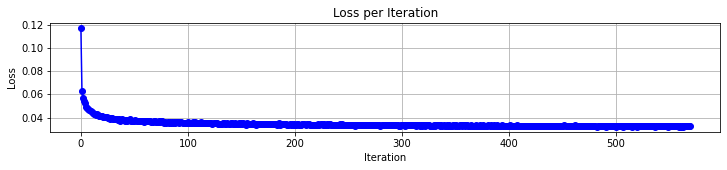

In [20]:
plt.figure(figsize=(12, 2))

# 반복 단위 손실 그래프
plt.plot(train_flatten, label='Train (per iter)', linestyle='-', marker='o', color='blue')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

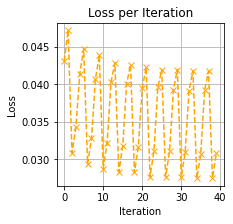

In [21]:
plt.plot(val_flatten, label='Validation (per iter)', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

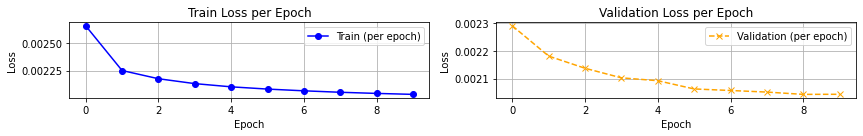

In [22]:
# 1행 2열 레이아웃 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 2))  # 그래프 크기 조정

# Train loss per epoch 그래프
axes[0].plot(train_loss_per_epoch, label='Train (per epoch)', linestyle='-', marker='o', color='blue')
axes[0].set_title("Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# Validation loss per epoch 그래프
axes[1].plot(val_loss_per_epoch, label='Validation (per epoch)', linestyle='--', marker='x', color='orange')
axes[1].set_title("Validation Loss per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

# 평가

In [124]:
!pwd

/root


In [125]:
%cd {root}/moanet

/root/moanet


In [126]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## batch size 16

### loss 추이 관찰

In [127]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('moanet.pth'))

<All keys matched successfully>

In [128]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

6025

In [129]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
        X_hat = model(X, prob)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  17%|█▋        | 1021/6025 [00:08<00:41, 120.96it/s]

train loss : 0.0341399178202264


Evaluating:  33%|███▎      | 2011/6025 [00:17<00:36, 109.93it/s]

train loss : 0.031285398218780756


Evaluating:  50%|█████     | 3015/6025 [00:26<00:27, 110.20it/s]

train loss : 0.032120417929487305


Evaluating:  67%|██████▋   | 4013/6025 [00:35<00:17, 112.46it/s]

train loss : 0.022680599342565985


Evaluating:  83%|████████▎ | 5020/6025 [00:44<00:08, 116.09it/s]

train loss : 0.0224078967703972


Evaluating: 100%|█████████▉| 6023/6025 [00:53<00:00, 114.00it/s]

train loss : 0.02021546224318445


Evaluating: 100%|██████████| 6025/6025 [00:54<00:00, 110.19it/s]


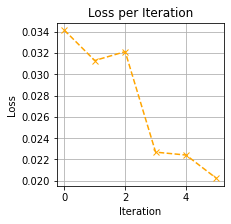

In [130]:
plt.plot(loss_list, label='Test', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

### 16개 개별비교

In [131]:
def visualize_patches_total(X, y, X_hat):

    fig, axes = plt.subplots(3, 16, figsize=(32, 6))  # 3행 16열로 설정
    fig.suptitle("Patches", fontsize=12, y=1.05)  # 전체 제목 추가

    for i in range(X.shape[0]):  # 16개의 이미지만큼 반복
        # X 데이터 시각화
        axes[0, i].imshow(X[i], cmap='gray', vmin=-200, vmax=300)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"X {i+1}", fontsize=12)

        # y 데이터 시각화
        axes[1, i].imshow(y[i], cmap='gray', vmin=-200, vmax=300)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"y {i+1}", fontsize=12)

        # X_hat 데이터 시각화
        axes[2, i].imshow(X_hat[i], cmap='gray', vmin=-200, vmax=300)
        axes[2, i].axis('off')
        axes[2, i].set_title(f"X_hat {i+1}", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # 제목 위치 조정
    plt.show()


In [132]:
# 1. 랜덤비교

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
test_iter = iter(test_loader)
len(test_iter)

6025

In [133]:
idx = 400 # 1~6025 여기 안에서 선택
for i in range(idx):
    (X_test,prob), y_test = next(test_iter)

In [134]:
prob.shape

torch.Size([16, 11])

In [135]:
X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(model(X_test.cuda(),prob.cuda()).cpu().detach()).numpy() * 500 - 500

In [136]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

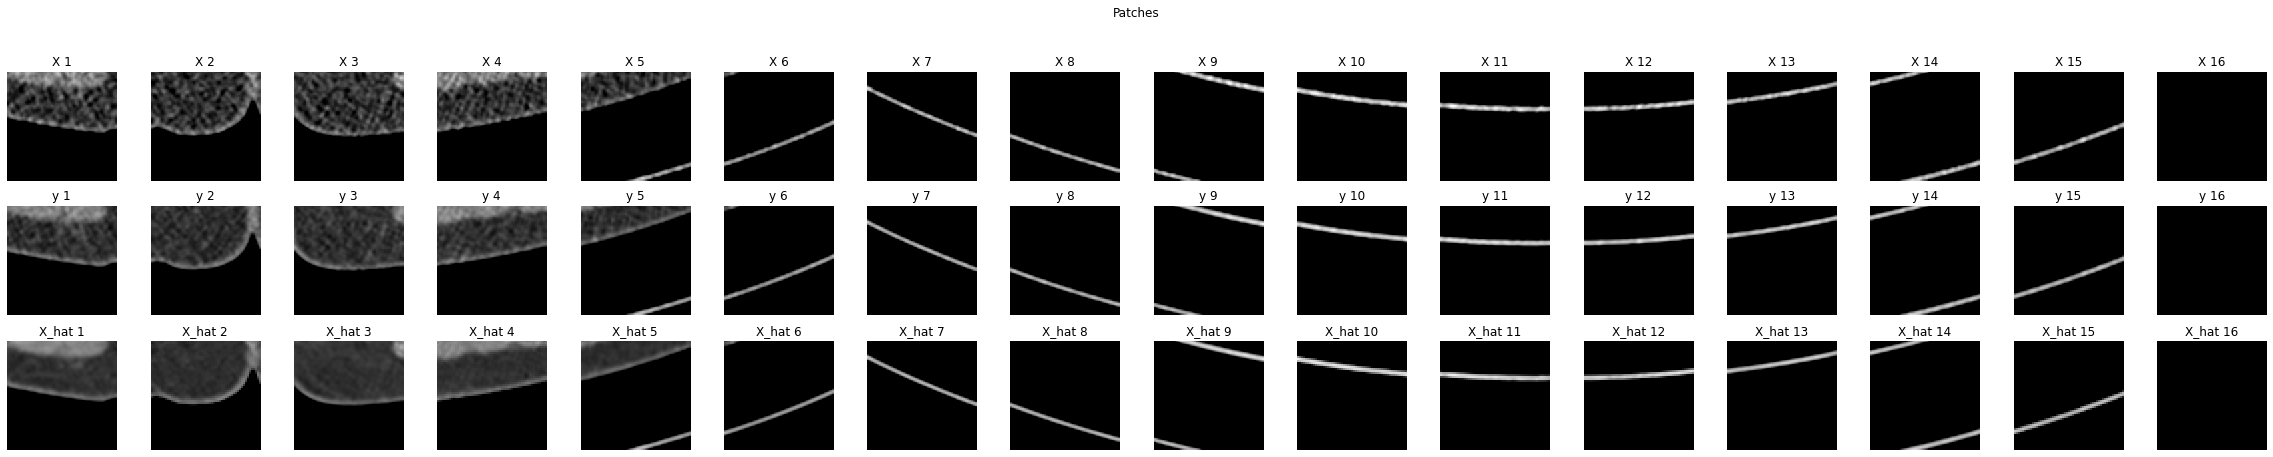

In [137]:
visualize_patches_total(X, y, X_hat)

In [138]:
# 2. 가장 loss가 낮은 값 확인

X_test,y_test,X_hat = best

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(X_hat.cpu().numpy()) * 500 - 500

In [139]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

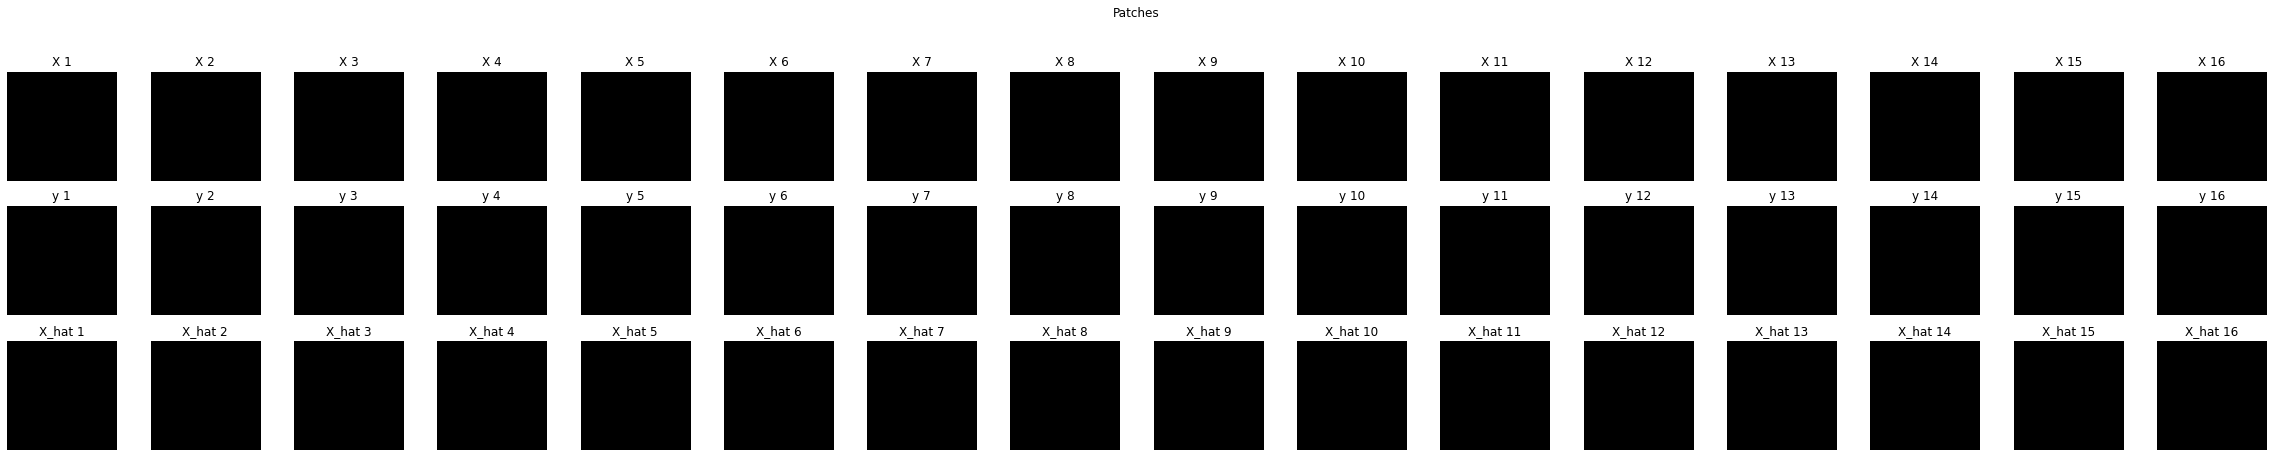

In [140]:
visualize_patches_total(X, y, X_hat)

In [141]:
# 3. 가장 loss가 높은 값 확인

X_test,y_test,X_hat = worst

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(X_hat.cpu().numpy()) * 500 - 500

In [142]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

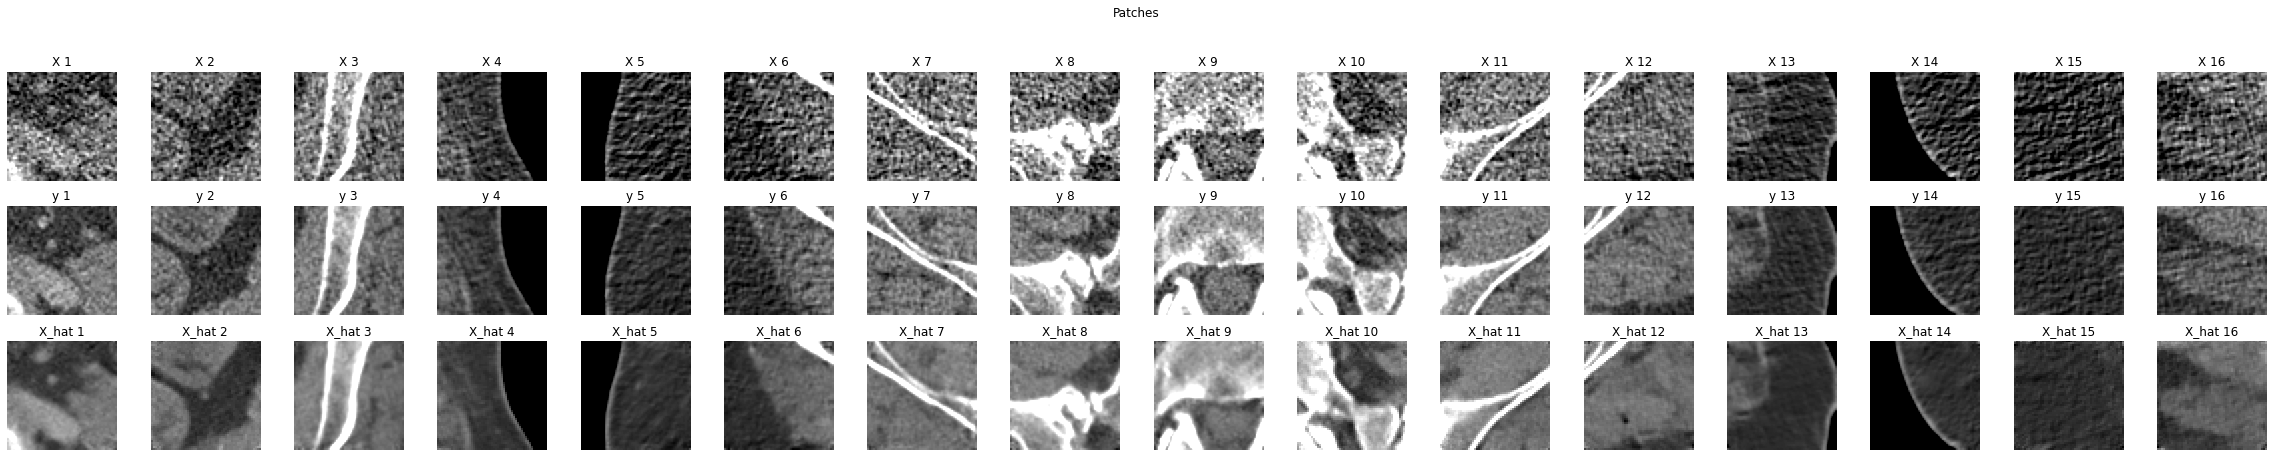

In [143]:
visualize_patches_total(X, y, X_hat)

## batch size = 81

In [144]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('moanet.pth'))

<All keys matched successfully>

In [145]:
test_loader = DataLoader(test_dataset, batch_size=81, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

1190

In [146]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
        X_hat = model(X, prob)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  84%|████████▍ | 1005/1190 [00:29<00:05, 32.43it/s]

train loss : 0.14414651690272148


Evaluating: 100%|██████████| 1190/1190 [00:39<00:00, 29.81it/s]


### 함수정의

In [147]:
def reconstruct_image(prediction, num_patches_per_row=9, patch_size=55):
    # prediction: (81, 1, 55, 55) 크기의 torch 텐서
    num_patches = prediction.shape[0]  # 81개의 패치
    assert prediction.shape == (81, 1, 55, 55) # "패치의 크기가 올바르지 않습니다."

    # 최종적으로 1x495x495 크기의 이미지를 만들기 위한 초기화
    final_image = torch.zeros(1, num_patches_per_row * patch_size, num_patches_per_row * patch_size)

    # 9x9 배열로 패치 붙이기
    for i in range(num_patches):
        row = i // num_patches_per_row  # 현재 패치의 행 번호
        col = i % num_patches_per_row   # 현재 패치의 열 번호

        # 패치를 해당 위치에 붙이기
        final_image[:,
                    row * patch_size:(row + 1) * patch_size,
                    col * patch_size:(col + 1) * patch_size] = prediction[i, 0]

    return final_image

In [148]:
def extract_patches(img, patch_size=55, interval=55):
    patches = []
    _, height, width = img.shape
    for y in range(0, height - patch_size + 1, interval):
        for x in range(0, width - patch_size + 1, interval):
            patch = img[:, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    patches = torch.stack(patches)  # 리스트를 텐서로 변환
    return patches  # 반환 형태는 patch 수 x 1 x 55 x 55

In [149]:
def rescale(img):
    return img*500-500 # -1000부터 2000의 값으로 다시 변환

In [150]:
def trans_img(X):
    return rescale(np.squeeze(reconstruct_image(X)))

In [151]:
X_test,y_test,X_hat = best
trans_img(X_test).min(), trans_img(X_test).max()

(tensor(-1024.), tensor(1915.))

In [152]:
!pwd

/root/moanet


In [153]:
def save_img(X_test, X_hat, y_test, s):
    # X_test 저장
    numpy_X_test = trans_img(X_test).numpy()
    np.save(f'X_test_image{s}.npy', numpy_X_test)

    # X_hat 저장
    numpy_X_hat = trans_img(X_hat).numpy()
    np.save(f'X_hat_image{s}.npy', numpy_X_hat)

    # y_test 저장
    numpy_y_test = trans_img(y_test).numpy()
    np.save(f'y_test_image{s}.npy', numpy_y_test)

### 1. best

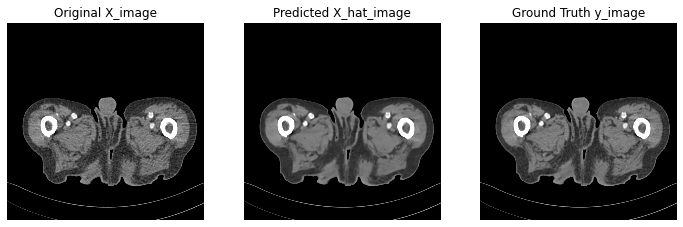

In [154]:
# 1. 가장 좋은 값 가져오기
X_test,y_test,X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [155]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'best')

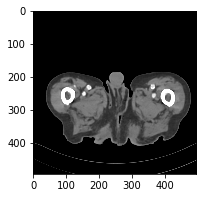

In [156]:
# 불러오기

import numpy as np

s = 'best'
X_test = np.load(f'X_hat_image{s}.npy')

plt.imshow(X_test, cmap='gray', vmin=-200, vmax=300)

### 2. worst

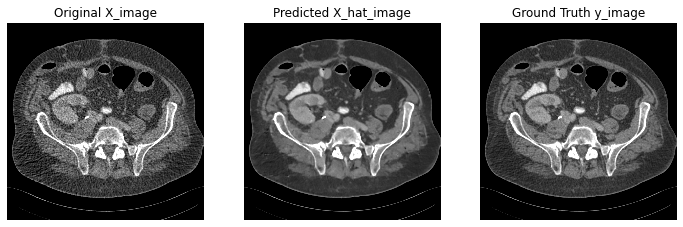

In [157]:
# 2. 가장 나쁜 값 가져오기
X_test,y_test,X_hat = worst

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [158]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'worst')

### 3. 랜덤

In [159]:
import glob
# 3. 랜덤선택

i,j = 0,0
X_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
y_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]

X_image, y_image = normlize(X_dir), normlize(y_dir)
X_patches = extract_patches(torch.from_numpy(X_image))

X_image.shape, y_image.shape, X_patches.shape

((1, 512, 512), (1, 512, 512), torch.Size([81, 1, 55, 55]))

In [160]:
import os
import pydicom
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# 이미지 불러오기
def load_dicom_image(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32)

    # 정규화 (0~1 사이로)
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)

    return Image.fromarray(img)

In [161]:
text_descriptions = [
    "skull",
    "ventricles",
    "lungs",
    "mediastinum",
    "liver",
    "kidneys",
    "pancreas",
    "spleen",
    "abdominal aorta",
    "spine",
    "lymph nodes"
]
len(text_descriptions)

11

In [162]:
import torch
from PIL import Image
from urllib.request import urlopen
from open_clip import create_model_from_pretrained, get_tokenizer

# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
clip_model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model.to(device)
clip_model.eval()

# 사용할 이미지
dicom_img = load_dicom_image(X_dir)
image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)
text_tokens = tokenizer(text_descriptions).to(device)

# 이미지 및 텍스트 전처리
image_input = preprocess(image).unsqueeze(0).to(device)
text_input = tokenizer(texts).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = clip_model(image_input, text_tokens)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

In [163]:
prob.shape

torch.Size([81, 11])

In [164]:
logits.shape

torch.Size([1, 11])

In [165]:
X_patches.shape

torch.Size([81, 1, 55, 55])

In [166]:
expanded_logits = logits.expand(81, -1)  # shape: [81, 11]
expanded_logits.shape

torch.Size([81, 11])

In [167]:
X_hat = model(X_patches.cuda(),expanded_logits.cuda())
X_hat.shape

torch.Size([81, 1, 55, 55])

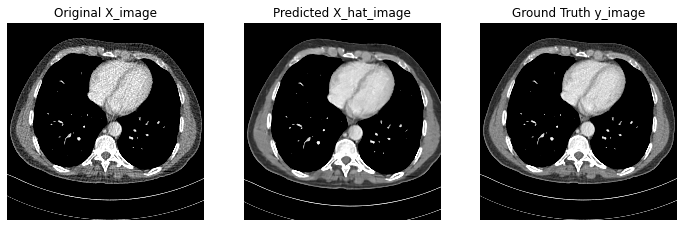

In [168]:
# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(rescale(np.squeeze(reconstruct_image(X_hat.detach().cpu()))), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [169]:
!pwd

/root/moanet


In [170]:
def recreat(X_dir):

    # X_patches
    X_img = normlize(X_dir)
    X_patches = extract_patches(torch.from_numpy(X_img))
    # prob
    dicom_img = load_dicom_image(X_dir)
    image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)
    text_tokens = tokenizer(text_descriptions).to(device)
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = tokenizer(texts).to(device)
    with torch.no_grad():
        image_features, text_features, logit_scale = clip_model(image_input, text_tokens)
        logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)
    expanded_logits = logits.expand(81, -1)
    # X_hat
    X_hat = model(X_patches.cuda(),expanded_logits.cuda())

    return reconstruct_image(X_hat.detach().cpu())

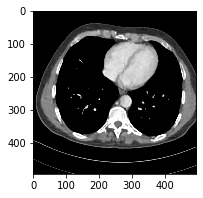

In [171]:
plt.imshow(rescale(np.squeeze(recreat(X_dir))), cmap='gray', vmin=-200, vmax=300)

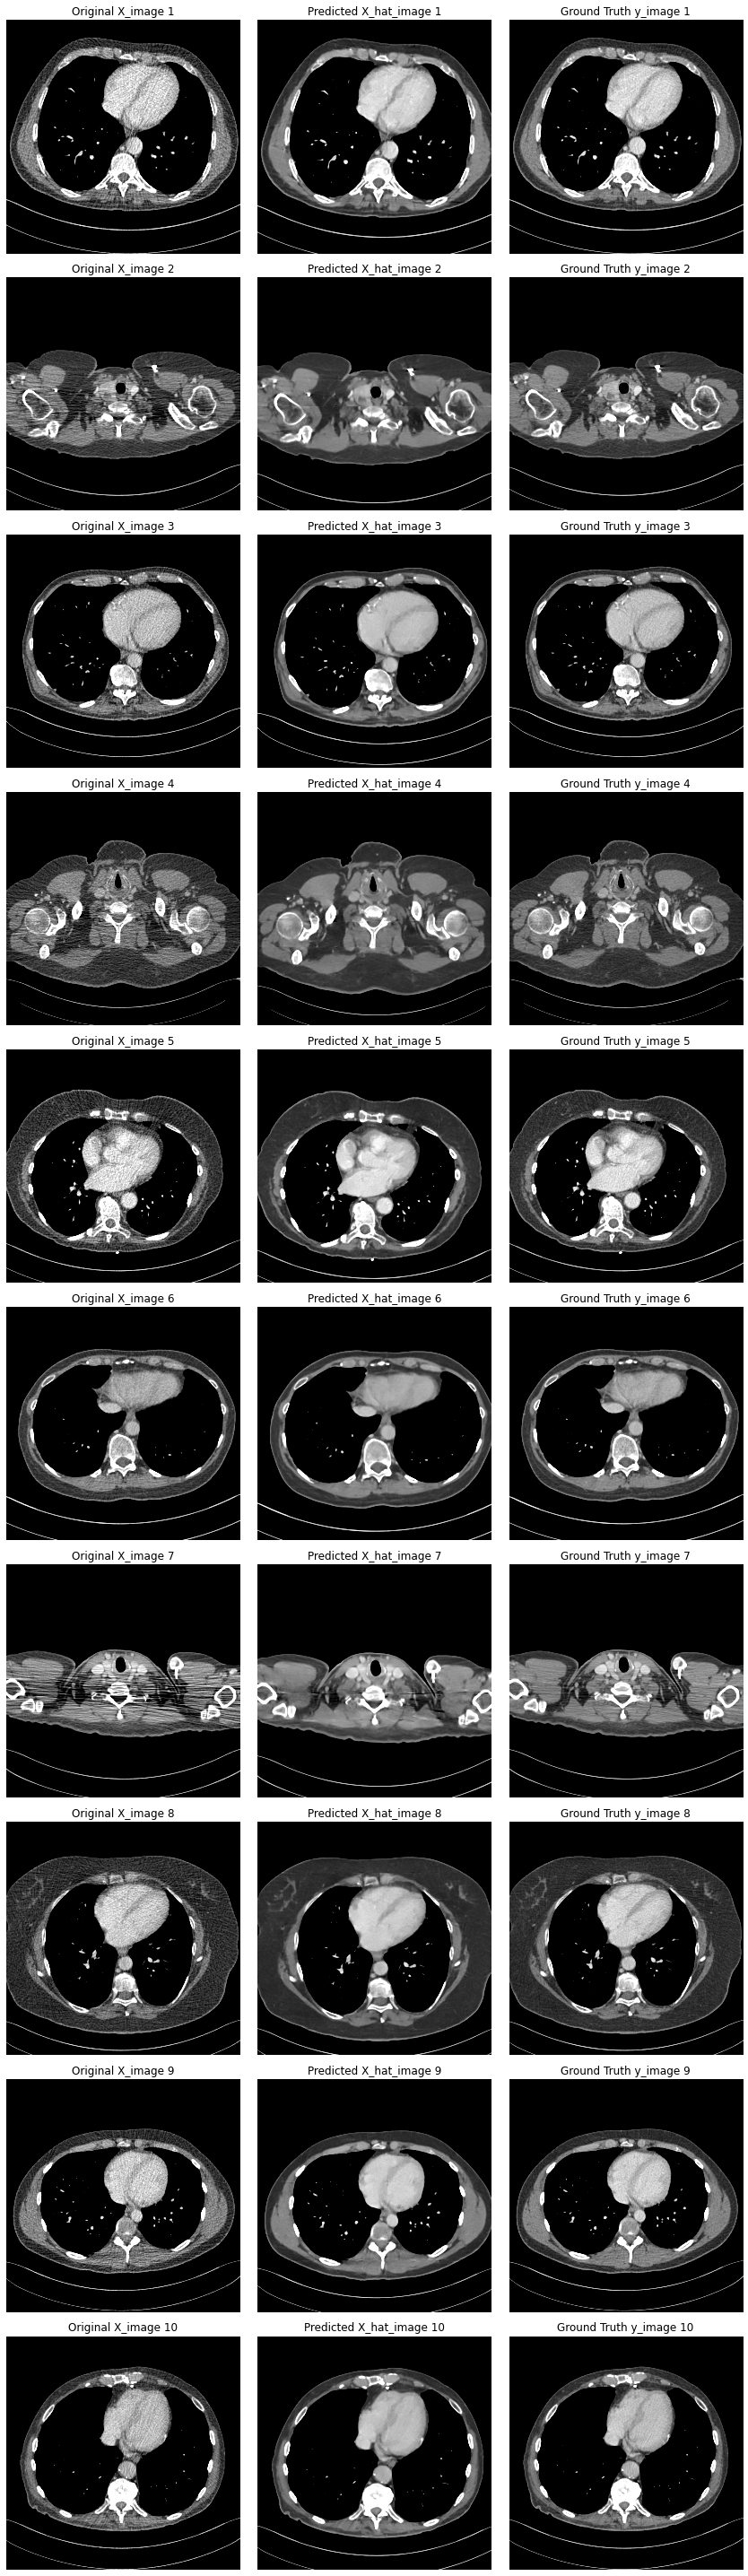

In [172]:
import matplotlib.pyplot as plt
import numpy as np

i, n = 0, 10
L = L_list[i]

# 전체 이미지 배열을 생성
fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    X_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
    y_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]
    X_image, y_image = normlize(X_dir), normlize(y_dir)
    X_patches = extract_patches(torch.from_numpy(X_image))
    reconstructed_image = recreat(X_dir)

    # X_image 표시
    axes[i, 0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 0].set_title(f"Original X_image {i+1}")
    axes[i, 0].axis('off')

    # X_hat_image 표시
    axes[i, 1].imshow(rescale(np.squeeze(reconstructed_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 1].set_title(f"Predicted X_hat_image {i+1}")
    axes[i, 1].axis('off')

    # y_image 표시
    axes[i, 2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 2].set_title(f"Ground Truth y_image {i+1}")
    axes[i, 2].axis('off')

# 모든 이미지 저장
plt.tight_layout()
plt.savefig("comparison_images.png", format="png")  # 한번에 저장
plt.show()  # 모든 이미지 표시

# attention 확인

In [173]:
# 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)

# 저장된 가중치 로드
model.load_state_dict(torch.load('moanet.pth'))
model.eval()

RedCNNWithSpatialAttention(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (spatial_attention3): SpatialAttention(
    (conv): Conv2d(2, 11, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (spatial_attention5): SpatialAttention(
    (conv): Conv2d(2, 11, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), 

## best / worst 이미지의 attention 확인

### 함수정의

In [174]:
def reconstruct_image(prediction, num_patches_per_row=9, patch_size=55):
    # prediction: (81, 1, 55, 55) 크기의 torch 텐서
    num_patches = prediction.shape[0]  # 81개의 패치

    # 최종적으로 1x495x495 크기의 이미지를 만들기 위한 초기화
    final_image = torch.zeros(1, num_patches_per_row * patch_size, num_patches_per_row * patch_size)

    # 9x9 배열로 패치 붙이기
    for i in range(num_patches):
        row = i // num_patches_per_row  # 현재 패치의 행 번호
        col = i % num_patches_per_row   # 현재 패치의 열 번호

        # 패치를 해당 위치에 붙이기
        final_image[:,
                    row * patch_size:(row + 1) * patch_size,
                    col * patch_size:(col + 1) * patch_size] = prediction[i, 0]

    return final_image

In [175]:
def extract_patches(img, patch_size=55, interval=55):
    patches = []
    _, height, width = img.shape
    for y in range(0, height - patch_size + 1, interval):
        for x in range(0, width - patch_size + 1, interval):
            patch = img[:, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    patches = torch.stack(patches)  # 리스트를 텐서로 변환
    return patches  # 반환 형태는 patch 수 x 1 x 55 x 55

In [176]:
def rescale(img):
    return img*500-500 # -1000부터 2000의 값으로 다시 변환

In [177]:
def trans_img(X):
    return rescale(np.squeeze(reconstruct_image(X)))

### 1. best

In [178]:
X_test,y_test,X_hat = best
X_test.shape

torch.Size([81, 1, 55, 55])

In [179]:
reconstruct_image(X_test).shape

torch.Size([1, 495, 495])

In [180]:
import torch
import torch.nn.functional as F
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer

# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
clip_model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model.to(device)
clip_model.eval()

image_tensor = reconstruct_image(X_test) # torch.Size([1, 495, 495])

# 텍스트
text_input = tokenizer(text_descriptions).to(device)

# Tensor를 BiomedCLIP이 처리할 수 있는 형태로 변환
def preprocess_tensor(img_tensor):
    # 1채널 → 3채널 (Grayscale → RGB)
    img_tensor = img_tensor.repeat(1, 3, 1, 1)  # (81, 1, 55, 55) → (81, 3, 55, 55)

    # 크기 조정 (55x55 → 224x224)
    img_tensor = F.interpolate(img_tensor, size=(224, 224), mode="bilinear", align_corners=False)

    return img_tensor

# 이미지 변환 후 BiomedCLIP 입력
image_input = preprocess_tensor(image_tensor).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = clip_model(image_input, text_input)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(text_descriptions):
    print(f'{text}: {logits[0][i].item():.4f}')

skull: 0.0006
ventricles: 0.5973
lungs: 0.3763
mediastinum: 0.0199
liver: 0.0001
kidneys: 0.0002
pancreas: 0.0000
spleen: 0.0032
abdominal aorta: 0.0022
spine: 0.0000
lymph nodes: 0.0002


In [181]:
logits_list = logits.squeeze(0)
logits_list.shape, logits_list.sum()

(torch.Size([11]), tensor(1., device='cuda:0'))

In [182]:
# prob
expanded_logits = logits.expand(81, -1)
expanded_logits.shape

torch.Size([81, 11])

In [183]:
X_test.shape, expanded_logits.shape

(torch.Size([81, 1, 55, 55]), torch.Size([81, 11]))

In [184]:
X_test.to(device)
output = model(X_test.cuda(), expanded_logits.cuda())
output.shape

torch.Size([81, 1, 55, 55])

In [185]:
# Forward Pass
output = model(X_test, expanded_logits)

att_matrix3 = model.spatial_attention3.last_attention
att_matrix5 = model.spatial_attention5.last_attention

att_matrix3.shape, att_matrix5.shape

(torch.Size([81, 11, 43, 43]), torch.Size([81, 11, 35, 35]))

여기서부터 시각화 확인

In [186]:
i = 0
selected_att_3 = att_matrix3[:, i, :, :].unsqueeze(1)
selected_att_3.shape

torch.Size([81, 1, 43, 43])

In [187]:
att_matrix3_img = reconstruct_image(prediction=selected_att_3, patch_size=att_matrix3.shape[-1])
att_matrix3_img.shape

torch.Size([1, 387, 387])

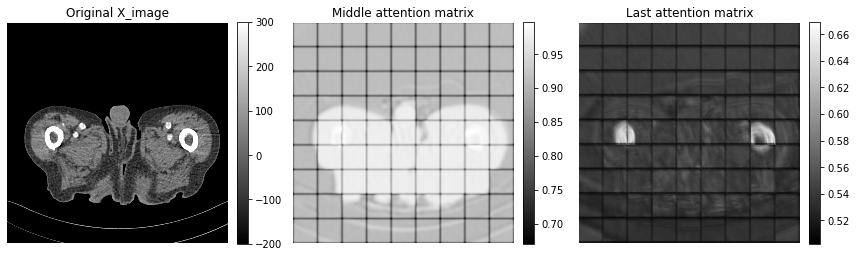

In [188]:
# 0번째 장기에 대한 attention
i = 0
selected_att_3 = att_matrix3[:, i, :, :].unsqueeze(1)
selected_att_5 = att_matrix5[:, i, :, :].unsqueeze(1)
att_matrix3_img = reconstruct_image(prediction=selected_att_3, patch_size=att_matrix3.shape[-1])
att_matrix5_img = reconstruct_image(prediction=selected_att_5, patch_size=att_matrix5.shape[-1])

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 첫 번째 이미지
im0 = axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# 두 번째 이미지
im1 = axes[1].imshow(np.squeeze(att_matrix3_img.detach().cpu().numpy()), cmap='gray')
axes[1].set_title("Middle attention matrix")
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# 세 번째 이미지
im2 = axes[2].imshow(np.squeeze(att_matrix5_img.detach().cpu().numpy()), cmap='gray')
axes[2].set_title("Last attention matrix")
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

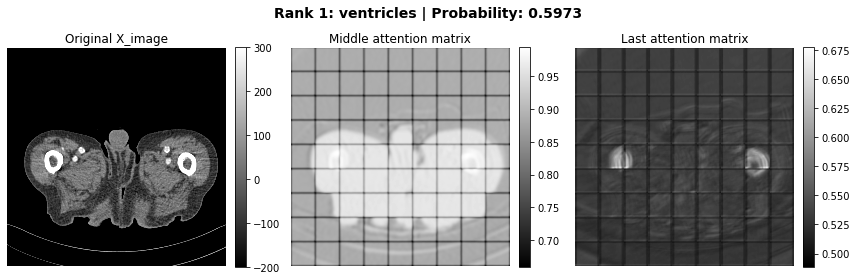

Saved: /root/output_images/base/best/rank_1_ventricles.png


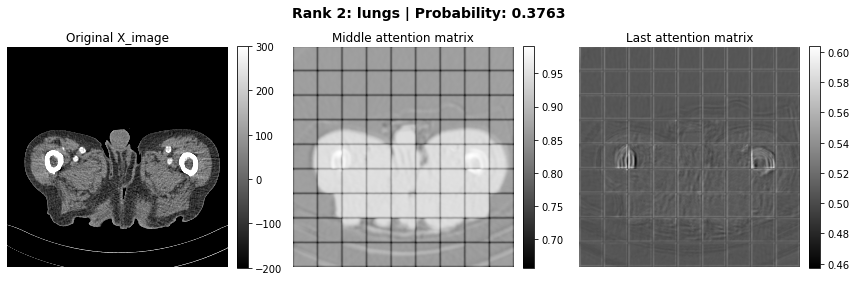

Saved: /root/output_images/base/best/rank_2_lungs.png


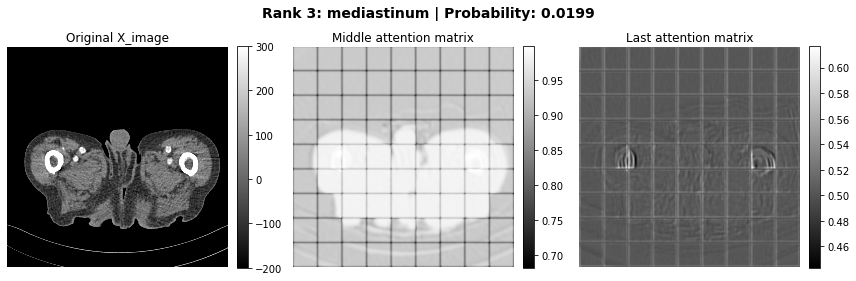

Saved: /root/output_images/base/best/rank_3_mediastinum.png


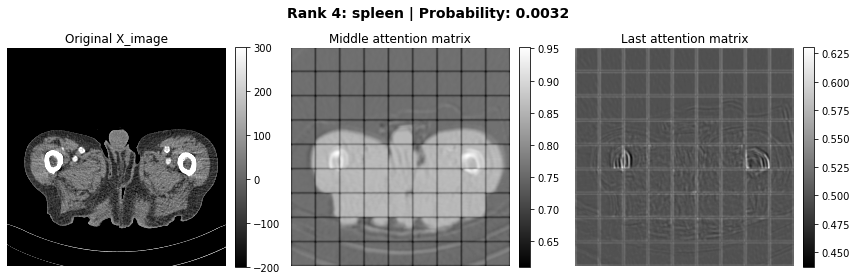

Saved: /root/output_images/base/best/rank_4_spleen.png


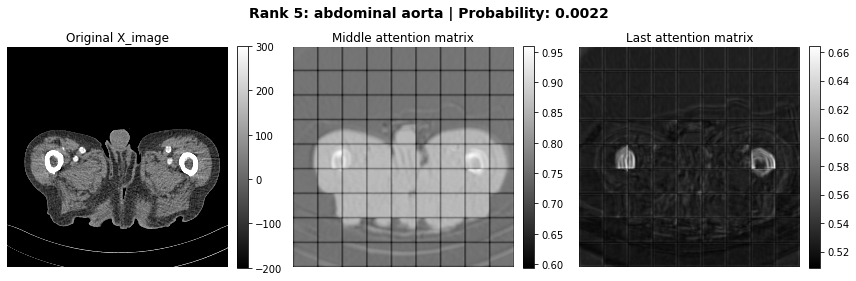

Saved: /root/output_images/base/best/rank_5_abdominal aorta.png


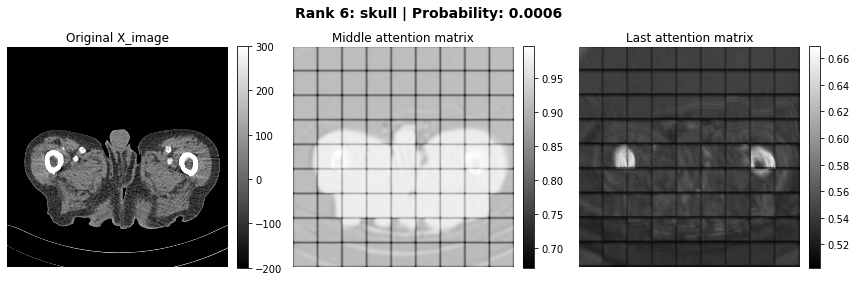

Saved: /root/output_images/base/best/rank_6_skull.png


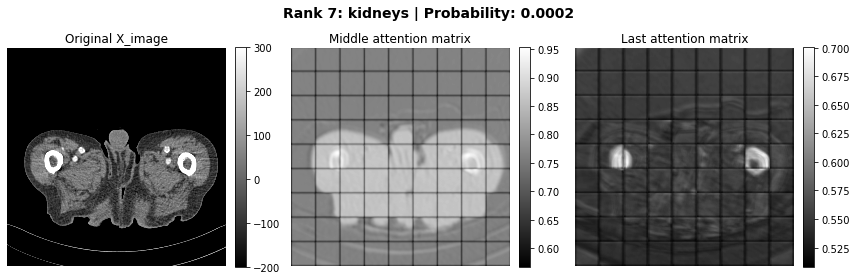

Saved: /root/output_images/base/best/rank_7_kidneys.png


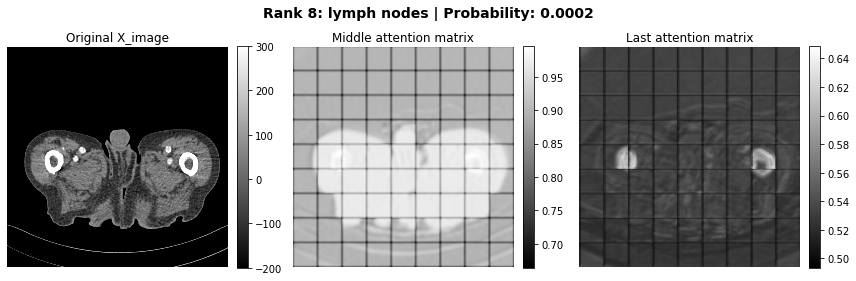

Saved: /root/output_images/base/best/rank_8_lymph nodes.png


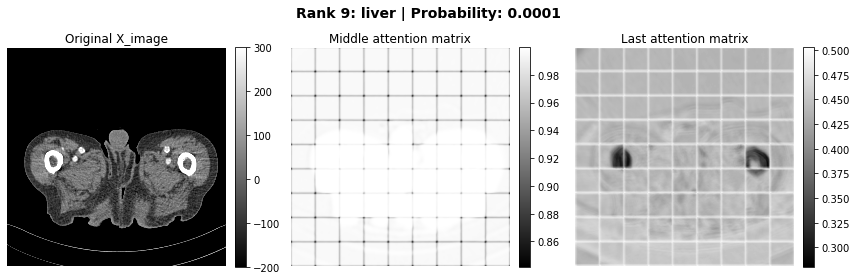

Saved: /root/output_images/base/best/rank_9_liver.png


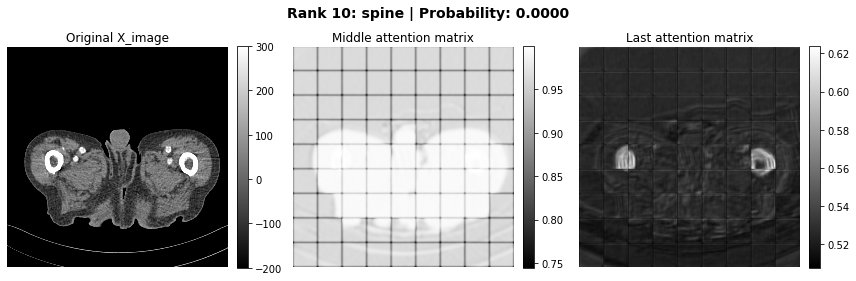

Saved: /root/output_images/base/best/rank_10_spine.png


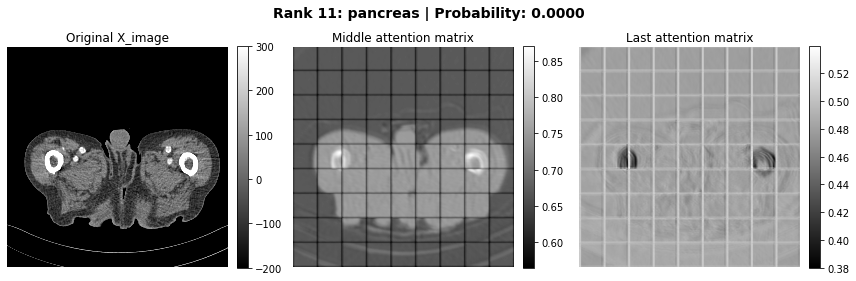

Saved: /root/output_images/base/best/rank_11_pancreas.png


In [189]:
import os

# 저장할 폴더 생성
save_dir = f"{root}/output_images/base/best"
os.makedirs(save_dir, exist_ok=True)

# 확률이 높은 순으로 정렬
sorted_indices = torch.argsort(logits_list, descending=True)  # 높은 확률 순으로 정렬
sorted_probs = logits_list[sorted_indices]  # 정렬된 확률값
sorted_organs = [text_descriptions[i] for i in sorted_indices]  # 정렬된 장기 이름

for rank, i in enumerate(sorted_indices):  # 정렬된 순서대로 반복
    selected_att_3 = att_matrix3[:, i, :, :].unsqueeze(1)
    selected_att_5 = att_matrix5[:, i, :, :].unsqueeze(1)

    att_matrix3_img = reconstruct_image(prediction=selected_att_3, patch_size=att_matrix3.shape[-1])
    att_matrix5_img = reconstruct_image(prediction=selected_att_5, patch_size=att_matrix5.shape[-1])

    organ_name = sorted_organs[rank]  # 현재 장기 이름
    probability = sorted_probs[rank].item()  # 현재 장기에 대한 확률

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Rank {rank+1}: {organ_name} | Probability: {probability:.4f}", fontsize=14, fontweight='bold')

    # 첫 번째 이미지
    im0 = axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
    axes[0].set_title("Original X_image")
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

    # 두 번째 이미지
    im1 = axes[1].imshow(np.squeeze(att_matrix3_img.detach().cpu().numpy()), cmap='gray')
    axes[1].set_title(f"Middle attention matrix")
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

    # 세 번째 이미지
    im2 = axes[2].imshow(np.squeeze(att_matrix5_img.detach().cpu().numpy()), cmap='gray')
    axes[2].set_title(f"Last attention matrix")
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout()

    # 이미지 저장
    save_path = os.path.join(save_dir, f"rank_{rank+1}_{organ_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved: {save_path}")

### 2. worst

In [190]:
X_test,y_test,X_hat = worst
X_test.shape

torch.Size([81, 1, 55, 55])

In [191]:
reconstruct_image(X_test).shape

torch.Size([1, 495, 495])

In [192]:
import torch
import torch.nn.functional as F
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer

# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
clip_model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model.to(device)
clip_model.eval()

image_tensor = reconstruct_image(X_test) # torch.Size([1, 495, 495])

# 텍스트
text_input = tokenizer(text_descriptions).to(device)

# Tensor를 BiomedCLIP이 처리할 수 있는 형태로 변환
def preprocess_tensor(img_tensor):
    # 1채널 → 3채널 (Grayscale → RGB)
    img_tensor = img_tensor.repeat(1, 3, 1, 1)  # (81, 1, 55, 55) → (81, 3, 55, 55)

    # 크기 조정 (55x55 → 224x224)
    img_tensor = F.interpolate(img_tensor, size=(224, 224), mode="bilinear", align_corners=False)

    return img_tensor

# 이미지 변환 후 BiomedCLIP 입력
image_input = preprocess_tensor(image_tensor).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = clip_model(image_input, text_input)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(text_descriptions):
    print(f'{text}: {logits[0][i].item():.4f}')

skull: 0.0032
ventricles: 0.0225
lungs: 0.0024
mediastinum: 0.1097
liver: 0.0001
kidneys: 0.0114
pancreas: 0.0000
spleen: 0.0034
abdominal aorta: 0.0054
spine: 0.8415
lymph nodes: 0.0003


In [193]:
logits_list = logits.squeeze(0)
logits_list.shape, logits_list.sum()

(torch.Size([11]), tensor(1.0000, device='cuda:0'))

In [194]:
# prob
expanded_logits = logits.expand(81, -1)
expanded_logits.shape

torch.Size([81, 11])

In [195]:
X_test.shape, expanded_logits.shape

(torch.Size([81, 1, 55, 55]), torch.Size([81, 11]))

In [196]:
X_test.to(device)
output = model(X_test.cuda(), expanded_logits.cuda())
output.shape

torch.Size([81, 1, 55, 55])

In [197]:
# Forward Pass
output = model(X_test, expanded_logits)

att_matrix3 = model.spatial_attention3.last_attention
att_matrix5 = model.spatial_attention5.last_attention

att_matrix3.shape, att_matrix5.shape

(torch.Size([81, 11, 43, 43]), torch.Size([81, 11, 35, 35]))

여기서부터 시각화 확인

In [198]:
i = 0
selected_att_3 = att_matrix3[:, i, :, :].unsqueeze(1)
selected_att_3.shape

torch.Size([81, 1, 43, 43])

In [199]:
att_matrix3_img = reconstruct_image(prediction=selected_att_3, patch_size=att_matrix3.shape[-1])
att_matrix3_img.shape

torch.Size([1, 387, 387])

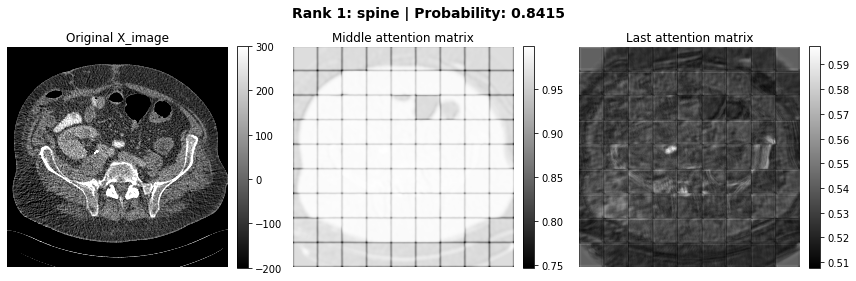

Saved: /root/output_images/base/worst/rank_1_spine.png


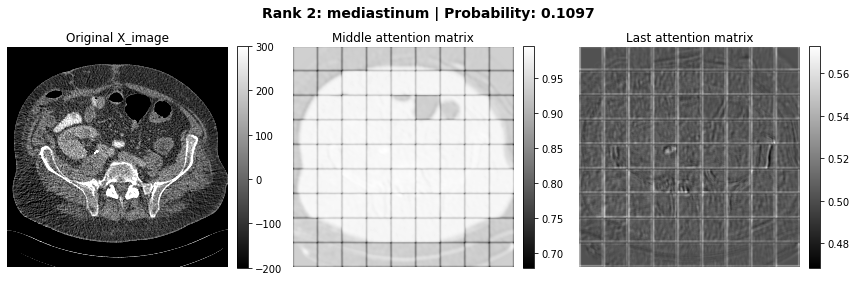

Saved: /root/output_images/base/worst/rank_2_mediastinum.png


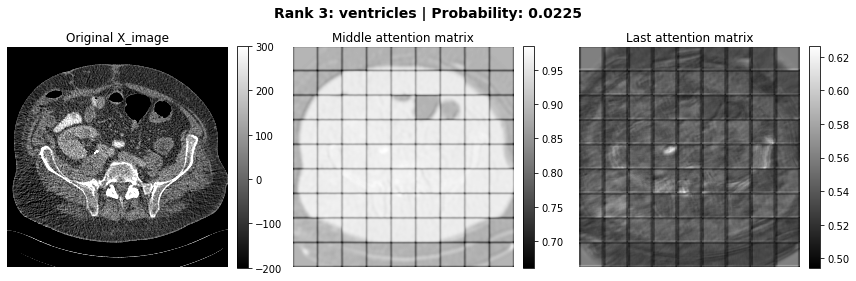

Saved: /root/output_images/base/worst/rank_3_ventricles.png


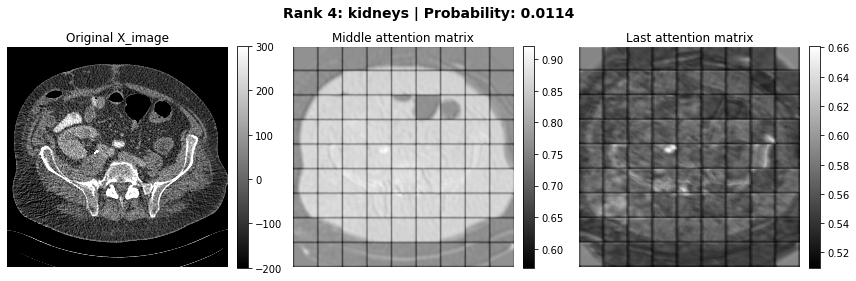

Saved: /root/output_images/base/worst/rank_4_kidneys.png


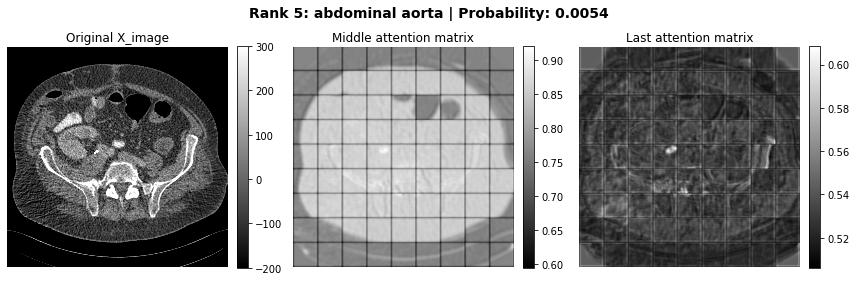

Saved: /root/output_images/base/worst/rank_5_abdominal aorta.png


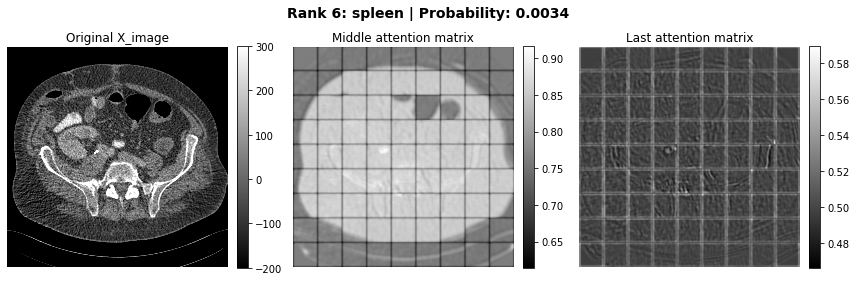

Saved: /root/output_images/base/worst/rank_6_spleen.png


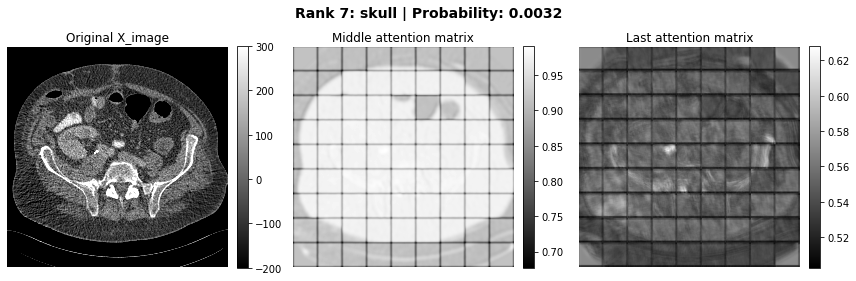

Saved: /root/output_images/base/worst/rank_7_skull.png


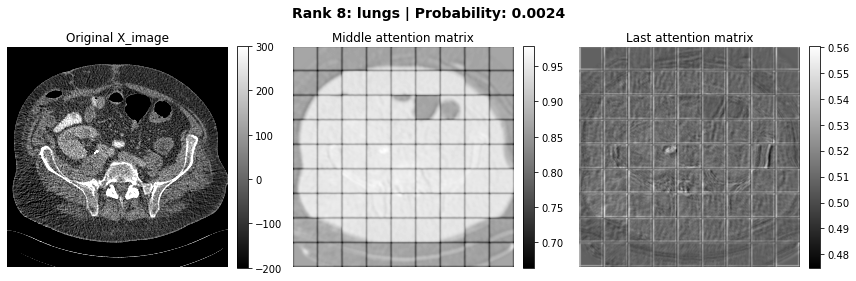

Saved: /root/output_images/base/worst/rank_8_lungs.png


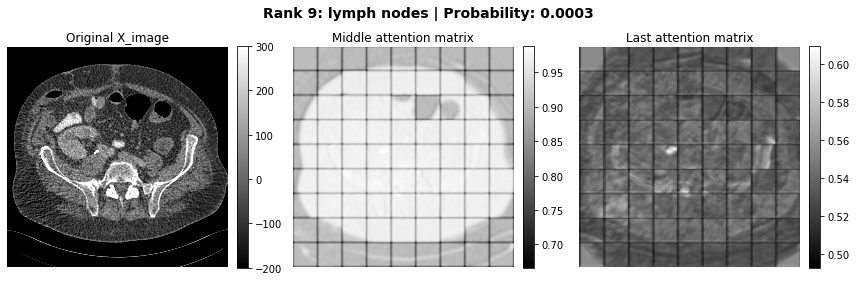

Saved: /root/output_images/base/worst/rank_9_lymph nodes.png


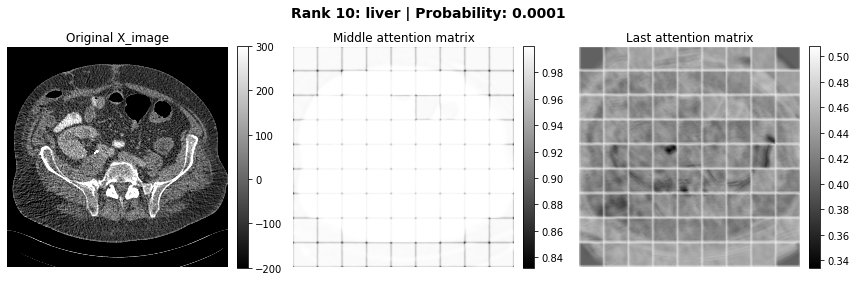

Saved: /root/output_images/base/worst/rank_10_liver.png


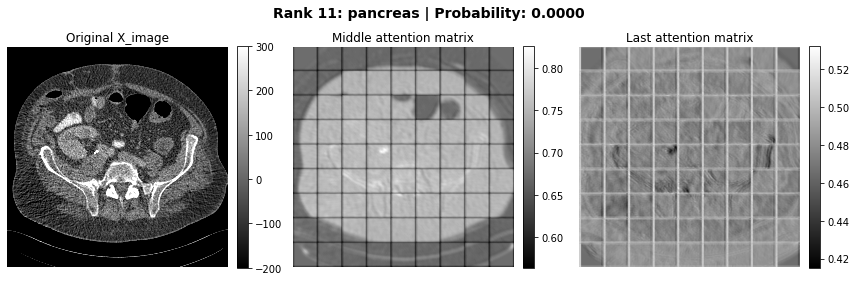

Saved: /root/output_images/base/worst/rank_11_pancreas.png


In [200]:
import os

# 저장할 폴더 생성
save_dir = f"{root}/output_images/base/worst"
os.makedirs(save_dir, exist_ok=True)

# 확률이 높은 순으로 정렬
sorted_indices = torch.argsort(logits_list, descending=True)  # 높은 확률 순으로 정렬
sorted_probs = logits_list[sorted_indices]  # 정렬된 확률값
sorted_organs = [text_descriptions[i] for i in sorted_indices]  # 정렬된 장기 이름

for rank, i in enumerate(sorted_indices):  # 정렬된 순서대로 반복
    selected_att_3 = att_matrix3[:, i, :, :].unsqueeze(1)
    selected_att_5 = att_matrix5[:, i, :, :].unsqueeze(1)

    att_matrix3_img = reconstruct_image(prediction=selected_att_3, patch_size=att_matrix3.shape[-1])
    att_matrix5_img = reconstruct_image(prediction=selected_att_5, patch_size=att_matrix5.shape[-1])

    organ_name = sorted_organs[rank]  # 현재 장기 이름
    probability = sorted_probs[rank].item()  # 현재 장기에 대한 확률

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Rank {rank+1}: {organ_name} | Probability: {probability:.4f}", fontsize=14, fontweight='bold')

    # 첫 번째 이미지
    im0 = axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
    axes[0].set_title("Original X_image")
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

    # 두 번째 이미지
    im1 = axes[1].imshow(np.squeeze(att_matrix3_img.detach().cpu().numpy()), cmap='gray')
    axes[1].set_title(f"Middle attention matrix")
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

    # 세 번째 이미지
    im2 = axes[2].imshow(np.squeeze(att_matrix5_img.detach().cpu().numpy()), cmap='gray')
    axes[2].set_title(f"Last attention matrix")
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout()

    # 이미지 저장
    save_path = os.path.join(save_dir, f"rank_{rank+1}_{organ_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved: {save_path}")